This file is for the training by gender.
The first cell splits the dataset by gender however it is not functional so not used for the rest of the notebook.
The model is based on the model in the file text_model-BERT.
Only the last layer is trained!! To train all layer remove the for loop setting require_grad to false (cell 4) and change model.classifier.parameters() to model.parameters() inside the optimizer (cell 4).

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn as nn
import torch.optim as optim
from functions_text_model import *
import os
import json

In [3]:
# Prepare dataset for training
data = pd.read_csv("sarcasm_data.csv")

# Split data by gender (F/M)
data_F = data[data['gender'] == 'F']
data_M = data[data['gender'] == 'M']

X_F = data_F['utterance']
y_F = data_F['sarcasm']

X_M = data_M['utterance']
y_M = data_M['sarcasm']

# Split data into training, validation, and test sets
X_F_train, X_F_temp, y_F_train, y_F_temp = train_test_split(X_F, y_F, test_size=0.2, random_state=42)
X_F_val, X_F_test, y_F_val, y_F_test = train_test_split(X_F_temp, y_F_temp, test_size=0.5, random_state=42)

X_M_train, X_M_temp, y_M_train, y_M_temp = train_test_split(X_M, y_M, test_size=0.2, random_state=42)
X_M_val, X_M_test, y_M_val, y_M_test = train_test_split(X_M_temp, y_M_temp, test_size=0.5, random_state=42)

In [4]:
# Tokenize data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#train_encodings = tokenizer(list(X_F_train), truncation=True, padding=True, return_tensors='pt')
#val_encodings = tokenizer(list(X_F_val), truncation=True, padding=True, return_tensors='pt')
#test_encodings = tokenizer(list(X_F_test), truncation=True, padding=True, return_tensors='pt')

#train_labels = torch.tensor(list(y_F_train))
#val_labels = torch.tensor(list(y_F_val))
#test_labels = torch.tensor(list(y_F_test))

In [6]:
# Load pre-trained BERT model
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the base BERT model
    num_labels = 2, # Binary classification (sarcasm or not)
    output_attentions = False, # Whether the model returns attentions weights
    output_hidden_states = False, # Whether the model returns all hidden-states
)

# Freeze BERT layers
for param in model.bert.parameters():
    param.requires_grad = False

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Modify model architecture

In [7]:
# Set hyperparameters
learning_rate = 0.0001
batch_size = 8
num_epochs = 5

In [12]:
# Function to encode the text
def encode_text(text):
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Input text
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attention masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

# PyTorch Dataset
class SarcasmDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        utterance = item['utterance']
        sarcasm = int(item['sarcasm'])
        input_ids, attention_mask = encode_text(utterance)
        return input_ids.flatten(), attention_mask.flatten(), sarcasm

# Create the DataLoader
# Load the data from the JSON file
with open('sarcasm_data.json') as f:
    data = json.load(f)

# Convert the data to a list of dictionaries
data = list(data.values())

dataset = SarcasmDataset(data)
dataloader = DataLoader(dataset, batch_size=32)

# Define the size of the training set and the test set
train_size = int(0.8 * len(dataset))  # 80% of the data for training
test_size = len(dataset) - train_size  # 20% of the data for testing

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

train Loss: 0.6773,  ACC: 0.5942, F1-weighted: 0.5592


100%|██████████| 18/18 [00:09<00:00,  1.89it/s]


eval Loss: 0.6947,  ACC: 0.4583, F1-weighted: 0.4367


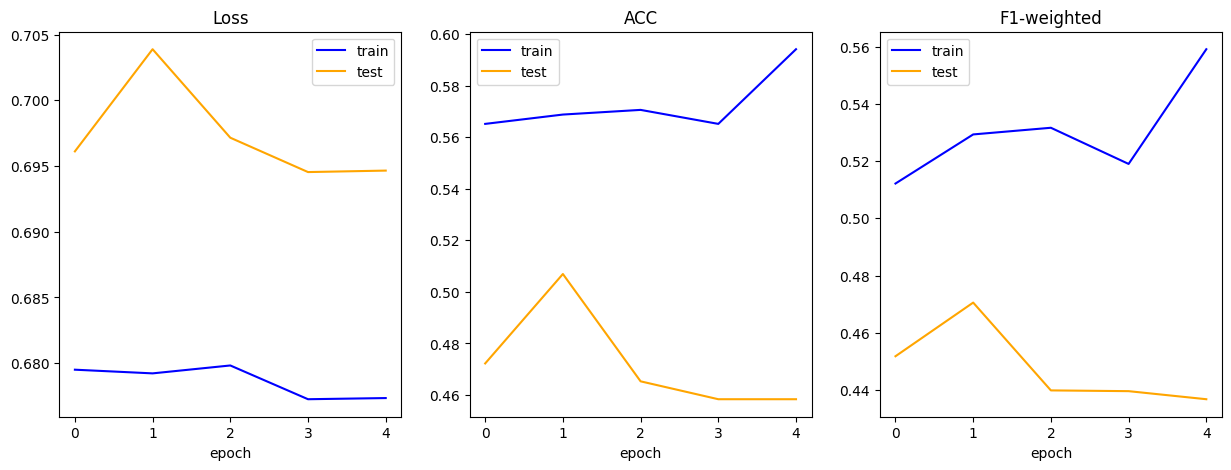

In [15]:
# Fine-tune the model
#torch.manual_seed(42)

device = torch.device("cpu")
model.to(device)

#train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels.long())
#val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels.long())

#train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

optimizer = optim.AdamW(model.classifier.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
metrics = {'ACC': acc, 'F1-weighted': f1}

print("start train cycle")
train_metrics_log, test_metrics_log = train_cycle(model, optimizer, criterion, metrics, train_dataloader, test_dataloader, n_epochs = num_epochs, device = device)

In [9]:
print(type(train_labels))
print(type(val_labels))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
# Save model weights
results_models_weights_dir = 'models_weights/'
if not os.path.exists(results_models_weights_dir):
    os.mkdir(results_models_weights_dir)
torch.save(model.state_dict(), results_models_weights_dir + 'base_model.pth')